In [1]:
import torch
import pickle as pkl
import numpy as np
import sys
from data_loader.datasets import DriveDataset
from skimage.filters import frangi
from sklearn import metrics
from matplotlib import pyplot as plt
import argparse
import cv2
%pylab
%matplotlib inline

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
def frangi_vesselness(img, i):
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    #img = clahe.apply((img*255).astype(np.uint8))/255.0
    ves = frangi(img, np.linspace(1, 5, 10), black_ridges=True).astype(np.float32)
    #print(ves.dtype)
    #ves = cv2.medianBlur(ves, 5)
    return ves


def vesselness_file(filename):
    with open(filename, 'rb') as fi:
        data = pkl.load(fi)

    def v(img, i):
        #return data[i, 0]
        img = cv2.medianBlur(data[i, 0], 5)
        return img
    return v



def get_vesselness(args):
    ''' Get vesselness from method '''
    if args.method == 'frangi':
        return frangi_vesselness
    elif args.method == 'file':
        return vesselness_file(args.file)
    else:
        raise NotImplementedError


def AUC(ves, gt, num=1000):
    tpr_list = []
    fpr_list = []
    pos = gt.mean()
    neg = 1 - pos
    # Get a percentile based threshold
    vflat = ves.reshape(-1)
    idx = np.argsort(vflat)
    N = len(idx)//num
    idx = idx[::N]
    perthres = vflat[idx][::-1]
    #for thres in np.linspace(ves.min(), ves.max(), num)[::-1]:
    for thres in perthres:
        v = (ves >= thres).astype(int)
        tpr = (v * gt).mean() / pos
        fpr = (v * (1-gt)).mean() / neg
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    # Given this, calculate the AUC using triangle method
    auc = 0
    for i in range(len(fpr_list)-1):
        f1 = fpr_list[i]
        f2 = fpr_list[i+1]
        t1 = tpr_list[i]
        t2 = tpr_list[i+1]
        dA = 0.5*(f2 - f1)*(t2 + t1)
        auc += dA

    return auc
    ## For plotting
    #plt.clf()
    #plt.plot(fpr_list, tpr_list)
    #plt.savefig('label.png')
    #sys.exit(0)


def AUC(ves, G, num=1000):
    v = (ves - ves.min())/(ves.max() - ves.min())
    gt = G.astype(int)
    fpr, tpr, thres = metrics.roc_curve(gt.reshape(-1), v.reshape(-1), pos_label=1)
    return metrics.auc(fpr, tpr)


def multiply_mask(ves, mask):
    m = ves.min()
    y, x = np.where(mask < 0.5)
    ves[y, x] = m
    return ves - m



In [7]:
dataset = DriveDataset( "/pghbio/dbmi/batmanlab/rohit33/DRIVE/", train=True, augment=False)
gtdataset = DriveDataset( "/pghbio/dbmi/batmanlab/rohit33/DRIVE/", train=True, toy=True, augment=False)

In [16]:
vfunc = vesselness_file('vesselness.pkl')


0.9382065519293774


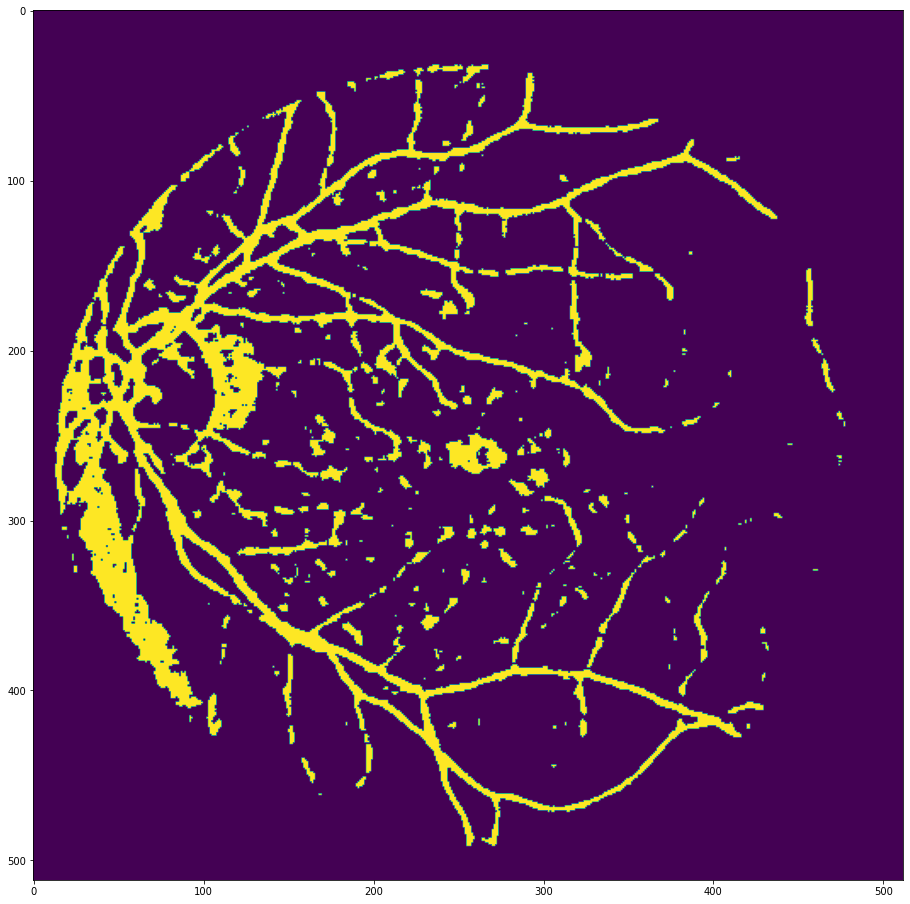

In [28]:
plt.figure(figsize=(16, 16))
for i in range(len(dataset)):
    img = dataset[i]['image'][0].data.cpu().numpy()
    lab = gtdataset[i]['image'][0].data.cpu().numpy()
    mask = dataset[i]['mask'][0].data.cpu().numpy()
    # Get vesselness
#     ves = frangi_vesselness(img, i)
    ves = vfunc(img, i)
    ves = multiply_mask(ves, mask)
    plt.imshow(ves**(0.5), 'jet')
    plt.imshow(ves > np.percentile(ves, 90))
    # plt.savefig('label.png')
    auc = AUC(ves, lab)
    print(auc)
    break